In [1]:
!pip install spacy

In [3]:
!python -m spacy download es

[+] Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
[x] Couldn't link model to 'es'
Creating a symlink in spacy/data failed. Make sure you have the required
permissions and try re-running the command as admin, or use a virtualenv. You
can still import the model as a module and call its load() method, or create the
symlink manually.
C:\Users\USER\.conda\envs\Data Science\lib\site-packages\es_core_news_sm -->
C:\Users\USER\.conda\envs\Data Science\lib\site-packages\spacy\data\es
[!] Download successful but linking failed
Creating a shortcut link for 'es' didn't work (maybe you don't have admin
permissions?), but you can still load the model via its full package name: nlp =
spacy.load('es_core_news_sm')


Carece de privilegios suficientes para realizar esta operación.


In [1]:
import spacy 

spacy.__version__

'2.1.4'

In [2]:
import torch
import torchtext
from torchtext import datasets

import re
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

### Twitter Sentiment Analysis Dataset
Source: http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/

In [3]:
tweets = pd.read_csv('datasets/tweets/tweets.csv', error_bad_lines = False)

tweets = tweets.head(50000)
tweets.head()

ItemID Sentiment SentimentSource  \
0       1       neg    Sentiment140   
1       2       neg    Sentiment140   
2       3       pos    Sentiment140   
3       4       neg    Sentiment140   
4       5       neg    Sentiment140   

                                       SentimentText  
0                       is so sad for my APL frie...  
1                     I missed the New Moon trail...  
2                            omg its already 7:30 :O  
3  .. Omgaga. Im sooo  im gunna CRy. I've been at...  
4           i think mi bf is cheating on me!!!   ...

The dataframe consists of 4 columns and we want to use only ‘Sentiment’ and ‘SentimentText’.

In [4]:
tweets  = tweets.drop(columns = ['ItemID', 'SentimentSource'], axis = 1)

tweets.head()

Sentiment                                      SentimentText
0       neg                       is so sad for my APL frie...
1       neg                     I missed the New Moon trail...
2       pos                            omg its already 7:30 :O
3       neg  .. Omgaga. Im sooo  im gunna CRy. I've been at...
4       neg           i think mi bf is cheating on me!!!   ...

In [5]:
tweets.shape

(50000, 2)

In [6]:
tweets['Sentiment'].unique()

array(['neg', 'pos'], dtype=object)

In [7]:
tweets.Sentiment.value_counts()

pos    26921
neg    23079
Name: Sentiment, dtype: int64

[Text(0.5, 0, 'Labels')]

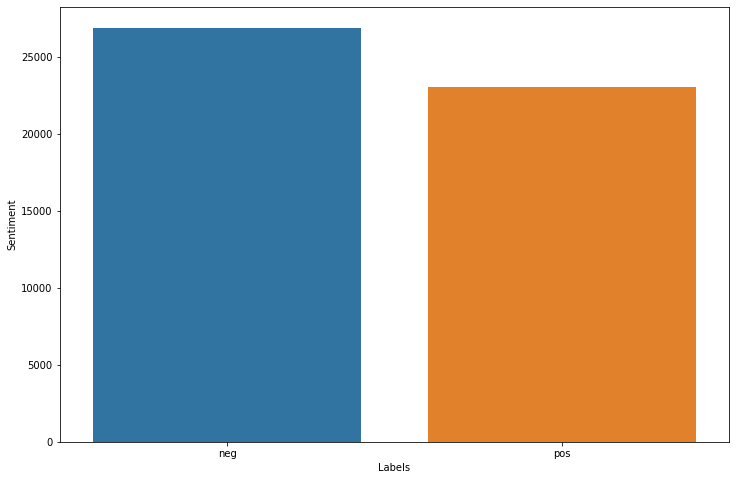

In [8]:
fig = plt.figure(figsize=(12, 8))

ax = sns.barplot(x=tweets.Sentiment.unique(), y=tweets.Sentiment.value_counts())

ax.set(xlabel='Labels')

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(tweets, test_size=0.2, random_state=42)

In [10]:
train.reset_index(drop=True), test.reset_index(drop=True)

(      Sentiment                                      SentimentText
 0           pos  @amyrenea omg so am I lol I fell asleep when i...
 1           neg               @Adrienne_Bailon I want a shout out 
 2           neg  @Anonymousboy03 Plans for school stuff &amp; a...
 3           neg  ... has hit a writer's block .. am loosing my ...
 4           neg  ... trying to find people I know! I`m bored, i...
 5           pos  &quot;Rise from your grave!&quot;ï¿½finalmente...
 6           pos                    @1RedDiamond it is where I live
 7           neg       @anthonystonem But I'm almost as fat as her 
 8           pos  @Addicted2Golf I am getting addicted.  Almost ...
 9           pos  @Abongachong Ahem, ignore the last tweet. Thou...
 10          pos                          *cough* LOL. Okay.  @LOXX
 11          pos                        @_huny enter the zoom lens 
 12          pos  ....ok, sOooooooooo I DID that!! i've got u in...
 13          pos  @28parkave well done you! I ne

In [11]:
train.head()

Sentiment                                      SentimentText
39087       pos  @amyrenea omg so am I lol I fell asleep when i...
30893       neg               @Adrienne_Bailon I want a shout out 
45278       neg  @Anonymousboy03 Plans for school stuff &amp; a...
16398       neg  ... has hit a writer's block .. am loosing my ...
13653       neg  ... trying to find people I know! I`m bored, i...

In [12]:
train.shape, test.shape

((40000, 2), (10000, 2))

In [13]:
train.to_csv('datasets/tweets/train_tweets.csv', index=False)
test.to_csv('datasets/tweets/test_tweets.csv', index=False)

In [14]:
!ls datasets/tweets

test_tweets.csv  train_tweets.csv tweets.csv


#### defining a funtion to clean the tweets by removing non alphanumeric character and links 

In [15]:
def tweet_clean(text):
    
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text) 
    text = re.sub(r'https?:/\/\S+', ' ', text) 
    
    return text.strip()

####  The tweet column (‘SentimentText’) needs processing and tokenization, so that it can be converted into indices.

In [16]:
nlp = spacy.load('en', disable=['parser', 'tagger', 'ner'])

def tokenizer(s): 
    return [w.text.lower() for w in nlp(tweet_clean(s))]

In [17]:
TEXT = torchtext.data.Field(tokenize = tokenizer)

LABEL = torchtext.data.LabelField(dtype = torch.float)

In [18]:
datafields = [('Sentiment', LABEL), ('SentimentText', TEXT)]

#### We create torchtext dataset,TabularDataset which is specially designed to read csv and tsv files and process them. It is a wrapper around pytorch Dataset with additional features. 

In [19]:
trn, tst = torchtext.data.TabularDataset.splits(path = 'datasets/tweets/', 
                                                train = 'train_tweets.csv',
                                                test = 'test_tweets.csv',    
                                                format = 'csv',
                                                skip_header = True,
                                                fields = datafields)

In [20]:
print(f'Number of training examples: {len(trn)}')
print(f'Number of testing examples: {len(tst)}')

Number of training examples: 40000
Number of testing examples: 10000


In [21]:
vars(trn.examples[0])

{'Sentiment': 'pos',
 'SentimentText': ['amyrenea',
  'omg',
  'so',
  'am',
  'i',
  'lol',
  'i',
  'fell',
  'asleep',
  'when',
  'it',
  'was',
  'on',
  'last',
  'night',
  'so',
  'now',
  'i',
  'get',
  'to',
  'finish',
  'it']}

In [22]:
vars(tst.examples[0])

{'Sentiment': 'pos',
 'SentimentText': ['aimeesays',
  'aww',
  'i',
  'hope',
  'it',
  'does',
  'fly',
  'by',
  'because',
  'jt',
  'episodes',
  'are',
  'usually',
  'really',
  'good',
  'and',
  'it',
  's',
  'early',
  'but',
  'so',
  'far',
  'this',
  'ep',
  'hassn',
  't',
  'disappointed']}

#### Load pretrained word vectors and build vocabulary
Now, instead of having our word embeddings initialized randomly, they are initialized with these pre-trained vectors. We get these vectors simply by specifying which vectors we want and passing it as an argument to build_vocab. TorchText handles downloading the vectors and associating them with the correct words in our vocabulary.

In [23]:
TEXT.build_vocab(trn, max_size=25000,
                 vectors="glove.6B.100d",
                 unk_init=torch.Tensor.normal_)

LABEL.build_vocab(trn)

In [24]:
print(TEXT.vocab.freqs.most_common(50))

[('i', 25644), ('the', 12219), ('to', 12111), ('you', 10723), ('a', 9197), ('it', 8440), ('and', 6889), ('my', 6208), ('quot', 5582), ('s', 5564), ('that', 5306), ('is', 5203), ('for', 4971), ('in', 4852), ('t', 4844), ('m', 4683), ('me', 4588), ('of', 4331), ('on', 3918), ('have', 3752), ('so', 3612), ('but', 3506), ('be', 2932), ('not', 2887), ('was', 2775), ('just', 2724), ('can', 2523), ('do', 2418), ('are', 2351), ('your', 2320), ('with', 2269), ('good', 2203), ('like', 2173), ('at', 2131), ('no', 2119), ('this', 2093), ('all', 2069), ('up', 2066), ('now', 2063), ('get', 2044), ('we', 1988), ('u', 1890), ('love', 1885), ('lol', 1864), ('too', 1826), ('what', 1760), ('out', 1742), ('know', 1664), ('nt', 1608), ('amp', 1539)]


In [25]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'i', 'the', 'to', 'you', 'a', 'it', 'and', 'my']


In [26]:
print(LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x119e5b268>, {'pos': 0, 'neg': 1})


#### Loading the data in batches
For data with variable length sentences torchtext provides BucketIterator() dataloader which is wrapper around pytorch Dataloader. 

In [27]:
train_iterator, test_iterator = torchtext.data.BucketIterator.splits(
                                (trn, tst),
                                batch_size = 64,
                                sort_key=lambda x: len(x.SentimentText),
                                sort_within_batch=False)

#### We'll be using a different RNN architecture called a Long Short-Term Memory (LSTM).

<b>torch.nn.embedding</b> -A simple lookup table that stores embeddings of a fixed dictionary and size.This module is often used to store word embeddings and retrieve them using indices. The input to the module is a list of indices, and the output is the corresponding word embeddings.


<b>LSTM</b> - Applies a multi-layer long short-term memory (LSTM) RNN to an input sequence.

<b>bidirectional</b> - an RNN processing the words in the sentence from the first to the last (a forward RNN), we have a second RNN processing the words in the sentence from the last to the first (a backward RNN). At time step $t$, the forward RNN is processing word $x_t$, and the backward RNN is processing word $x_{T-t+1}$.


<b>Dropout</b> - it works by randomly dropping out (setting to 0) neurons in a layer during a forward pass. The probability that each neuron is dropped out is set by a hyperparameter and each neuron with dropout applied is considered indepenently.This helps in regularization.


In [112]:
import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, 
                 output_dim, n_layers, bidirectional, dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers = n_layers, 
                           bidirectional = bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        
        self.dropout = nn.Dropout(dropout)

        
    def forward(self, text):
        
        embedded = self.dropout(self.embedding(text))
        
        output, hidden = self.rnn(embedded)
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
       
        return self.fc(hidden.squeeze(0))

To ensure the pre-trained vectors can be loaded into the model, the EMBEDDING_DIM must be equal to that of the pre-trained GloVe vectors loaded earlier.

We get our pad token index from the vocabulary, getting the actual string representing the pad token from the field's pad_token attribute, which is pad by default.

In [113]:
input_dim = len(TEXT.vocab)

embedding_dim = 100

hidden_dim = 20
output_dim = 1

n_layers = 2
bidirectional = True

dropout = 0.5

In [114]:
model = RNN(input_dim, 
            embedding_dim, 
            hidden_dim, 
            output_dim, 
            n_layers, 
            bidirectional, 
            dropout)

In [115]:
model

RNN(
  (embedding): Embedding(25002, 100)
  (rnn): GRU(100, 20, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
  (dropout): Dropout(p=0.5)
)

We retrieve the embeddings from the field's vocab, and check they're the correct size, [vocab size, embedding dim]

In [116]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([25002, 100])


We then replace the initial weights of the embedding layer with the pre-trained embeddings.

In [117]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.2017,  0.6970, -0.5827,  ..., -1.1129, -0.5033, -0.7208],
        [ 0.2141,  0.9815,  1.8029,  ...,  0.3049,  1.0668, -0.7111],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [ 1.2380,  1.5805, -0.2643,  ..., -0.4007, -0.0272,  0.7074],
        [ 2.3054, -1.1257,  1.1538,  ...,  0.2036,  0.5751, -0.3229],
        [-0.8496, -1.0295,  1.6804,  ..., -0.7246, -0.3404,  1.6258]])

As our < unk > and < pad > token aren't in the pre-trained vocabulary they have been initialized using unk_init (an $\mathcal{N}(0,1)$ distribution) when building our vocab. It is preferable to initialize them both to all zeros to explicitly tell our model that, initially, they are irrelevant for determining sentiment.

In [118]:
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [ 1.2380,  1.5805, -0.2643,  ..., -0.4007, -0.0272,  0.7074],
        [ 2.3054, -1.1257,  1.1538,  ...,  0.2036,  0.5751, -0.3229],
        [-0.8496, -1.0295,  1.6804,  ..., -0.7246, -0.3404,  1.6258]])


#### Train the Model

We use Adam optimizer and loss function is BCEWithLogitLoss 

In [119]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

#### We define a function for training our model
as we are now using dropout, we must remember to use model.train() to ensure the dropout is "turned on" while training.

In [120]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.SentimentText).squeeze(1)
        
        loss = criterion(predictions, batch.Sentiment)
        
        rounded_preds = torch.round(torch.sigmoid(predictions))
        correct = (rounded_preds == batch.Sentiment).float() 
        
        acc = correct.sum() / len(correct)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [121]:
num_epochs = 10

for epoch in range(num_epochs):
     
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% |')

| Epoch: 01 | Train Loss: 0.645 | Train Acc: 61.55% |
| Epoch: 02 | Train Loss: 0.541 | Train Acc: 73.29% |
| Epoch: 03 | Train Loss: 0.499 | Train Acc: 76.19% |
| Epoch: 04 | Train Loss: 0.470 | Train Acc: 77.93% |
| Epoch: 05 | Train Loss: 0.447 | Train Acc: 79.41% |
| Epoch: 06 | Train Loss: 0.428 | Train Acc: 80.52% |
| Epoch: 07 | Train Loss: 0.411 | Train Acc: 81.66% |
| Epoch: 08 | Train Loss: 0.394 | Train Acc: 82.52% |
| Epoch: 09 | Train Loss: 0.377 | Train Acc: 83.41% |
| Epoch: 10 | Train Loss: 0.363 | Train Acc: 84.44% |


### Testing the model

In [122]:
epoch_loss = 0
epoch_acc = 0

model.eval()

with torch.no_grad():

    for batch in test_iterator:

        predictions = model(batch.SentimentText).squeeze(1)

        loss = criterion(predictions, batch.Sentiment)

        rounded_preds = torch.round(torch.sigmoid(predictions))
        correct = (rounded_preds == batch.Sentiment).float() 
        
        acc = correct.sum()/len(correct)

        epoch_loss += loss.item()
        epoch_acc += acc.item()


test_loss = epoch_loss / len(test_iterator)
test_acc = epoch_acc / len(test_iterator)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.493 | Test Acc: 77.05%


#### User Input
We can now use our model to predict the sentiment of any sentence we give it.As it has been trained on tweets, the sentences provided should in a positive or a negative context.

We are expecting tweets with a negative sentiment to return a value close to 1 and positive tweets to return a value close to 0


In [123]:
sentence = 'I hate that show' 

#Run again for "That movie was really nice"
#Run again for "I hate that show but recently it has been quite good"
#Run again for "That movie was decent but kind of fizzled out towards the end"

In [124]:
tokenized = [tok.text for tok in nlp.tokenizer(sentence)]

In [125]:
indexed = [TEXT.vocab.stoi[t] for t in tokenized]

In [126]:
tensor = torch.LongTensor(indexed)

In [127]:
tensor = tensor.unsqueeze(1)

In [128]:
prediction = torch.sigmoid(model(tensor))

In [129]:
prediction.item()

0.8913049101829529